# DeepSets Architecture

This notebook implements the end-to-end DeepSets architecture to predict label from the set of images of a patient


### Set up

In [2]:
import pandas as pd
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.transforms import v2

from sklearn.model_selection import train_test_split
import torch.nn as nn

from time import time

import torchvision.models as models
import csv
import cv2
from skimage.morphology import binary_dilation,disk
from tqdm import tqdm

#import sys
#sys.path.append("../")
#import preprocess_metadata
warnings.filterwarnings("ignore")


In [3]:
!pip install -q gdown==v5.1.0
import gdown
file_id = "1aFL2eAJJSjcSV3yuOBHc6ZgJ1jGC29eB"
output_file = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)
!unzip -q dataset.zip
!rm dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1aFL2eAJJSjcSV3yuOBHc6ZgJ1jGC29eB
From (redirected): https://drive.google.com/uc?id=1aFL2eAJJSjcSV3yuOBHc6ZgJ1jGC29eB&confirm=t&uuid=93f9de11-55d3-48ed-a288-b1cab302fb1d
To: /content/dataset.zip
100%|██████████| 299M/299M [00:02<00:00, 102MB/s]


## Load metadata

In [4]:
def preprocess_metadata(path_data='dataset/'):
    """
    Preprocesses metadata from clinical annotation CSV file.
    """
    df = pd.read_csv(path_data+"/clinical_annotation.csv",index_col="ID")
    df['DOB'] = pd.to_datetime(df['DOB'])
    current_year = 2024
    df['AGE'] = current_year - df['DOB'].dt.year
    sex_mapping = {'M': 0, 'F': 1, 'm':0, 'f':1}
    df['GENDER'] = df['GENDER'].map(sex_mapping)
    df =  df.drop(df.columns[0], axis=1)
    df.drop('DOB', axis=1, inplace=True)
    train_set = df[df['LABEL'].isin([0, 1])]
    test_set = df[df['LABEL'] == -1]

    # Add a column for the train set to indicate the subgroup used for stratification
    thresh_lymph_count = train_set["LYMPH_COUNT"].median()
    thresh_age = train_set["AGE"].median()

    # Store the 3 binary variables
    train_meta_binary = pd.DataFrame(index=train_set.index)
    train_meta_binary["LYMPH_COUNT"] = train_set["LYMPH_COUNT"] > thresh_lymph_count
    train_meta_binary["AGE"] = train_set["AGE"] > thresh_age
    train_meta_binary["LABEL"] = train_set["LABEL"]

    train_set["SUBGROUP"] = train_meta_binary["LYMPH_COUNT"] + 2*train_meta_binary["AGE"] + 4*train_meta_binary["LABEL"]

    return train_set, test_set



In [6]:
train_set_meta, test_set_meta = preprocess_metadata(path_data="dataset")
print("Number of train patients",train_set_meta.shape[0])
print("Number of train patients of class 0 :", train_set_meta[train_set_meta['LABEL'] == 0].shape[0])
print("Number of train patients of class 1 :", train_set_meta[train_set_meta['LABEL'] == 1].shape[0])
print("Number of test patients",test_set_meta.shape[0])

Number of train patients 163
Number of train patients of class 0 : 50
Number of train patients of class 1 : 113
Number of test patients 42


In [7]:
train_set_meta

,LABEL,GENDER,LYMPH_COUNT,AGE,SUBGROUP
ID,,,,,
P26,1,0,11.20,91,7
P183,1,0,12.80,82,7
P89,1,0,9.60,89,7
P123,1,0,122.60,93,7
P61,1,1,11.60,93,7
...,...,...,...,...,...
P135,1,0,9.45,73,5
P8,0,0,4.91,49,0
P130,0,1,4.17,81,2


## Dataset

In [8]:
class Patient:
    def __init__(self, ID, age, gender, lymph_count, label, images_path,
                 max_images=None):
        self.ID = ID
        self.age = age
        self.gender = gender
        self.lymph_count = lymph_count
        self.images_path = images_path
        self.label = label
        self.image_list = self.load_images(max_images=max_images)
        self.nb_images = len(self.image_list)

    def load_images(self, max_images=None):
        image_list = []
        fnames = os.listdir(self.images_path)

        if max_images is not None and max_images < len(fnames):
            fnames = np.random.choice(fnames, max_images, replace=False)

        for image_file in fnames:
            image_path = os.path.join(self.images_path, image_file)
            image = Image.open(image_path).convert("RGB")
            image_list.append(np.array(image))

        return image_list


    def __str__(self):
        return f"Patient ID: {self.ID}, Age: {self.age}, Gender: {self.gender}, Lymphocyte Count: {self.lymph_count}, Label: {self.label}, Number of Images: {self.nb_images}"


In [9]:
class PatientsDataset(Dataset):
    def __init__(self, folder_path, patient_ids, metadata, transform, max_images=None):
        self.patients = []

        print("Load patients from ", folder_path, "...")
        for patient in tqdm(patient_ids): #os.listdir(folder_path)):
            patient_path = os.path.join(folder_path, patient)
            if not os.path.isdir(patient_path):
                continue
            patient_info = metadata.loc[patient]
            ID = int(patient[1:])

            if "testset" in folder_path:
                self.patients.append(Patient(ID, patient_info['AGE'], patient_info['GENDER'],
                                         patient_info['LYMPH_COUNT'], np.nan,
                                         patient_path, max_images=max_images))

            else:
                self.patients.append(Patient(ID, patient_info['AGE'], patient_info['GENDER'],
                                         patient_info['LYMPH_COUNT'], patient_info['LABEL'],
                                         patient_path, max_images=max_images))
        print("\nDone!")

        np.random.shuffle(self.patients)
        self.transform = transform
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    def __len__(self):
        return len(self.patients)

    def __getitem__(self,i):
        """
        Returns a tuple with the augmented images, the metadata tensor and the label tensor
        """
        patient = self.patients[i]
        image_tensor = torch.tensor(np.array(patient.image_list), dtype=torch.float, device=self.device).permute(0, 3, 1, 2)
        image_tensor = self.transform(image_tensor)
        metadata = torch.tensor([(patient.age-70)/30, patient.gender-0.5, (patient.lymph_count-10)/10],
                                dtype=torch.float, device=self.device)
        return image_tensor, metadata, torch.tensor(patient.label, dtype=torch.float, device=self.device)

In [10]:
# Transformation combining data augmentation with normalization
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomApply(torch.nn.ModuleList([v2.RandomRotation((90, 90))]), p=0.5),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
trainset_folder = "dataset/trainset"
valid_ratio = 0.4
train_fnames, valid_fnames = train_test_split(train_set_meta.index, test_size=valid_ratio, stratify=train_set_meta["SUBGROUP"])

In [18]:
trainset = PatientsDataset("dataset/trainset", train_fnames, train_set_meta, transform)
validset = PatientsDataset("dataset/trainset", valid_fnames, train_set_meta, transform)
testset = PatientsDataset("dataset/testset", test_set_meta.index, test_set_meta, transform)

print(f"Number of train patients: {len(trainset)}")
print(f"Number of validation patients: {len(validset)}")
print(f"Number of test patients: {len(testset)}")


Load patients from  dataset/trainset ...


100%|██████████| 97/97 [00:06<00:00, 14.04it/s]



Done!
Load patients from  dataset/trainset ...


100%|██████████| 66/66 [00:03<00:00, 16.57it/s]



Done!
Load patients from  dataset/testset ...


100%|██████████| 42/42 [00:02<00:00, 17.40it/s]


Done!
Number of train patients: 97
Number of validation patients: 66
Number of test patients: 42


## Model

In [14]:
class MLP(nn.Module):
    def __init__(self, dimensions, activation, final_activation):
        super(MLP, self).__init__()
        self.activation = activation
        self.final_activation = final_activation

        layers = []
        for i in range(len(dimensions)-1):
            layers.append(nn.Linear(dimensions[i], dimensions[i+1]))

        self.layers = nn.Sequential(*layers)

    def forward(self, input):
        x = self.layers[0](input)

        for layer in self.layers[1:]:
            x = self.activation(x)
            x = layer(x)

        x = self.final_activation(x)
        return x

class EnsembleNetwork(nn.Module):
    def __init__(self, backbone, embedding_dim, freeze_backbone=True):
        super(EnsembleNetwork, self).__init__()

        if freeze_backbone:
            for param in backbone.parameters():
                param.requires_grad = False

        self.backbone = backbone

        self.featuresMLP = MLP([embedding_dim, 128, 32], nn.ReLU(), nn.ReLU())
        self.metadataMLP = MLP([3, 8], nn.ReLU(), nn.ReLU())
        self.classificationMLP = MLP([32+8, 16, 8, 1], nn.ReLU(), nn.Identity())


    def forward(self, images, metadata):
        # Takes as the input the tensor all the images of a single patient
        feat = self.backbone(images).squeeze(2, 3)

        #feat = feat.max(dim=0)[0].unsqueeze(0) # Maxpooling aggregation
        feat = feat.mean(dim=0).unsqueeze(0) # Mean aggregation

        feat = self.featuresMLP(feat)

        metadata_embeddings = self.metadataMLP(metadata)

        concat = torch.cat((feat, metadata_embeddings), dim=1)

        return self.classificationMLP(concat)

### Instantiate the model

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])

torch.random.manual_seed(0)
ensembleNet = EnsembleNetwork(backbone, 512, freeze_backbone=False)#512 for resnet, 6656 for ensembleNet
_ = ensembleNet.to(device)

In [26]:
batch_size = 16
epochs = 5

bceLoss = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(ensembleNet.parameters())

dataloader_train = DataLoader(trainset,
                              batch_size=1,
                              shuffle=True)

dataloader_valid = DataLoader(validset,
                              batch_size=1,
                              shuffle=True)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
start_epoch_indices = []


for e in range(epochs):
    print("\nStart epoch", e)
    start_epoch_indices.append(len(train_losses))
    batch_loss = 0
    correct_predictions = 0

    # Training
    print("Training")
    for k, patient in tqdm(enumerate(dataloader_train)):
        images, metadata, label = patient
        pred = ensembleNet(images[0], metadata)
        loss = bceLoss(pred.reshape(-1), label)
        loss.backward()
        batch_loss += loss.detach().cpu().numpy()
        correct_predictions += ((pred.reshape(-1)>0.5)==label).detach().cpu().numpy()

        if (k+1) % batch_size==0:
            optim.step()
            optim.zero_grad()
            train_losses.append(batch_loss / batch_size)
            train_accuracies.append(correct_predictions / batch_size)
            batch_loss = 0
            correct_predictions = 0

    print("Train loss", np.mean(train_losses[start_epoch_indices[-1]]), "Accuracy", np.mean(train_accuracies[start_epoch_indices[-1]]))

    # Validation
    print("Validation")
    with torch.no_grad():
      valid_correct_predictions = 0
      valid_loss_epoch = 0
      valid_batch_loss = 0
      for k, patient in tqdm(enumerate(dataloader_valid)):
          images, metadata, label = patient
          pred = ensembleNet(images[0], metadata)
          loss = bceLoss(pred.reshape(-1), label)
          valid_batch_loss += loss.detach().cpu().numpy()
          valid_correct_predictions += ((pred.reshape(-1)>0.5)==label).detach().cpu().numpy()

      valid_losses.append(valid_batch_loss / k)
      valid_accuracies.append(valid_correct_predictions / k)

    print("Valid loss", np.mean(valid_losses[-1]), "Accuracy", np.mean(valid_accuracies[-1]))
torch.save(ensembleNet, "ensembleNet")


Start epoch 0
Training


97it [00:29,  3.29it/s]


Train loss 0.6218489930033684 Accuracy 0.25
Validation


66it [00:08,  7.77it/s]


Valid loss 0.627972398354457 Accuracy 0.7076923076923077

Start epoch 1
Training


97it [00:28,  3.40it/s]


Train loss 0.6212903559207916 Accuracy 0.6875
Validation


66it [00:08,  7.89it/s]


Valid loss 0.6146395307320814 Accuracy 0.7076923076923077

Start epoch 2
Training


97it [00:28,  3.41it/s]


Train loss 0.6159281022846699 Accuracy 0.6875
Validation


66it [00:08,  7.72it/s]


Valid loss 0.618915379505891 Accuracy 0.7076923076923077

Start epoch 3
Training


97it [00:29,  3.31it/s]


Train loss 0.5611283015459776 Accuracy 0.75
Validation


66it [00:11,  5.83it/s]


Valid loss 0.6094990679850945 Accuracy 0.7076923076923077

Start epoch 4
Training


97it [00:29,  3.26it/s]


Train loss 0.6366031728684902 Accuracy 0.625
Validation


66it [00:09,  6.64it/s]

Valid loss 0.605137393107781 Accuracy 0.7076923076923077


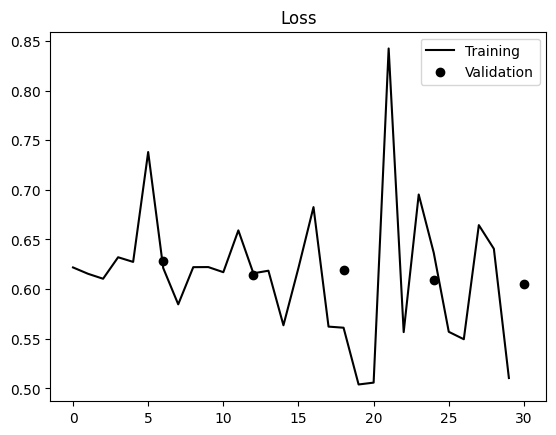

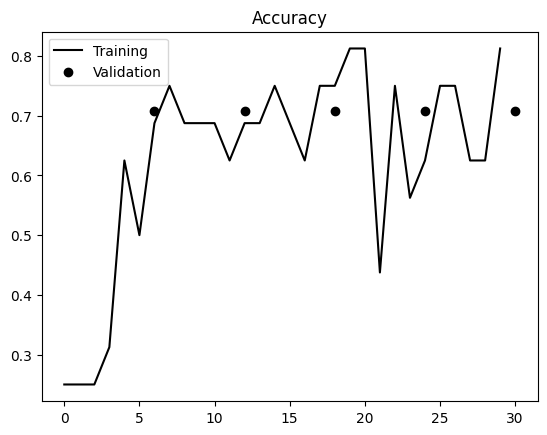

In [28]:
end_epochs_indices = np.array(start_epoch_indices) + start_epoch_indices[1]

plt.plot(train_losses, color="Black", label="Training")
plt.scatter(end_epochs_indices, valid_losses, color="Black", label="Validation")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, color="Black", label="Training")
plt.scatter(end_epochs_indices, valid_accuracies, color="Black", label="Validation")
plt.title("Accuracy")
plt.legend()
plt.show()


## Inference on the test set

In [30]:
model = ensembleNet

In [31]:
# Generate predictions for the test set
predictions = []
with torch.no_grad():
    predictions = {}
    for i in range(len(testset)):
        images, metadata, _ = testset[i]
        pred = ensembleNet(images, metadata.unsqueeze(0))

        predictions[testset.patients[i].ID] = int((pred > 0.5).cpu().numpy().reshape(-1))

print(predictions)

with open('predictions.csv', 'w') as f:
    f.write("ID,Predicted\n")
    for patient_id, prediction in predictions.items():
        f.write(f"P{patient_id},{prediction}\n")


{139: 1, 132: 1, 71: 1, 143: 1, 16: 1, 172: 1, 68: 1, 93: 1, 133: 1, 18: 1, 4: 1, 56: 1, 119: 1, 197: 1, 170: 1, 81: 1, 49: 1, 203: 1, 24: 1, 175: 1, 69: 1, 9: 1, 92: 1, 58: 1, 195: 1, 57: 1, 178: 1, 108: 1, 14: 1, 148: 1, 188: 1, 120: 1, 73: 1, 7: 1, 75: 1, 98: 1, 32: 1, 196: 1, 86: 1, 114: 1, 152: 1, 138: 1}
